In [1]:
%matplotlib inline
import pickle
from pandas import DataFrame
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt


state_df = pickle.load(open("test/local_node/state/0x85Cb0baB616Fe88a89A35080516a8928F38B518b_df.pkl", "rb"))
state_df.head()

,sender,to,amount0In,amount1In,amount0Out,amount1Out,block,reserve0,reserve1
0,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0,1000000000000000000,17216867992651970607,0,11876000,25851205000000000000,500000000000000000
1,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,172168679926519706,0,0,29238993545300586,11876000,8634337007348029393,1500000000000000000
2,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x6775e49108cb77cda06Fc3BEF51bcD497602aD88,0,224702378222482754,1220961301500860191,0,11876017,13596682010212464215,2270761006454699413
3,0x7a250d5630B4cF539739dF2C5dAcb4c659F2488D,0x6775e49108cb77cda06Fc3BEF51bcD497602aD88,0,274957939374967319,1224941726101556768,0,11876020,12375720708711604024,2495463384677182167
4,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,0x9320f3013d78b0f3957cC016A9B9b61FDFcCA1D6,17044699312725450901,0,0,1672781398369595795,11876026,11150778982610047256,2770421324052149486


# Transform Swap Index to a per Block Index

Our data was collected by scanning for swaps. In
order to properly introduce the idea of how long a price existed at a given time and be able to shift by block, we can index our data per block. 

In [2]:
block_df = (state_df[['block', 'amount0In', 'amount1In', 'amount0Out', 'amount1Out', 'reserve0', 'reserve1']]).groupby(
    state_df.block, as_index=False).agg({
        'block': 'first', 'amount0In': sum, 'amount1In': sum, 'amount0Out': sum, 'amount1Out': sum, 'reserve0': 'first', 'reserve1': 'first'
    })
block_df.block = block_df.block.astype(int)

block_df = block_df.set_index('block').reindex(np.arange(block_df.block.min(), block_df.block.max() + 1)).reset_index()
block_df.reserve0 = block_df.reserve0.fillna(method='bfill')
block_df.reserve1 = block_df.reserve1.fillna(method='bfill')
block_df = block_df.fillna(value=0)


In [3]:
block_df.head()

,block,amount0In,amount1In,amount0Out,amount1Out,reserve0,reserve1
0,11876000,172168679926519706,1000000000000000000,17216867992651970607,29238993545300586,25851205000000000000,500000000000000000
1,11876001,0,0,0,0,13596682010212464215,2270761006454699413
2,11876002,0,0,0,0,13596682010212464215,2270761006454699413
3,11876003,0,0,0,0,13596682010212464215,2270761006454699413
4,11876004,0,0,0,0,13596682010212464215,2270761006454699413


# Construct Oracles

Our dataframe starts with swaps and reserves prior to swaps. Using this data we crunch some numbers to build build various oraclse. Since we do not have time which our scanner does not grab, we use blocks thus BWAP rather than TWAP. If every block was 12 seconds exactly, this would be the same, but since that is not the case, there are some minor erorrs. 

In [4]:
tick_log = math.log(1.0001)


# additive TWAP
oracle_df = block_df
oracle_df["cumsum_x_per_y"] = (block_df['reserve0'] / block_df['reserve1']).cumsum()
oracle_df["cumsum_y_per_x"] = (block_df['reserve1'] / block_df['reserve0']).cumsum()


oracle_df["twap_30_x_per_y"] = (oracle_df["cumsum_x_per_y"] - oracle_df["cumsum_x_per_y"].shift(periods=150)) / 150
oracle_df["twap_30_y_per_x"] = (oracle_df["cumsum_y_per_x"] - oracle_df["cumsum_y_per_x"].shift(periods=150)) / 150
oracle_df["twap_60_x_per_y"] = (oracle_df["cumsum_x_per_y"] - oracle_df["cumsum_x_per_y"].shift(periods=300)) / 300
oracle_df["twap_60_y_per_x"] = (oracle_df["cumsum_y_per_x"] - oracle_df["cumsum_y_per_x"].shift(periods=300)) / 300

# Geometric TWAP
oracle_df["tick_sum_x_per_y"] = (np.log((block_df['reserve0'] / block_df['reserve1']).astype(float)) /
                                tick_log).cumsum()

oracle_df["geom_twap_30_x_per_y"] = np.power(
    1.0001, (oracle_df["tick_sum_x_per_y"] - oracle_df["tick_sum_x_per_y"].shift(150)) / 150
)
oracle_df["geom_twap_60_x_per_y"] = np.power(
    1.0001, (oracle_df["tick_sum_x_per_y"] - oracle_df["tick_sum_x_per_y"].shift(300)) / 300
)


# VWAP
oracle_df["cumsum_x_in"] = block_df["amount0In"].cumsum()
oracle_df["cumsum_y_out"] = block_df["amount1Out"].cumsum()
oracle_df["cumsum_y_in"] = block_df["amount1In"].cumsum()
oracle_df["cumsum_x_out"] = block_df["amount0Out"].cumsum()

oracle_df["vwap_30_x_per_y"] = (
        oracle_df["cumsum_x_in"] + oracle_df["cumsum_x_out"] -
        (oracle_df["cumsum_x_in"] + oracle_df["cumsum_x_out"]).shift(150)).divide(
        (oracle_df["cumsum_y_in"] + oracle_df["cumsum_y_out"] -
        (oracle_df["cumsum_y_in"] + oracle_df["cumsum_y_out"]).shift(150)).replace({ 0 : np.nan }))


In [5]:

oracle_df.head()

,block,amount0In,amount1In,amount0Out,amount1Out,reserve0,reserve1,cumsum_x_per_y,cumsum_y_per_x,twap_30_x_per_y,...,twap_60_x_per_y,twap_60_y_per_x,tick_sum_x_per_y,geom_twap_30_x_per_y,geom_twap_60_x_per_y,cumsum_x_in,cumsum_y_out,cumsum_y_in,cumsum_x_out,vwap_30_x_per_y
0,11876000,172168679926519706,1000000000000000000,17216867992651970607,29238993545300586,25851205000000000000,500000000000000000,51.70241,0.019341,NaN,...,NaN,NaN,39457.016674,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
1,11876001,0,0,0,0,13596682010212464215,2270761006454699413,57.69013,0.18635,NaN,...,NaN,NaN,57355.019242,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
2,11876002,0,0,0,0,13596682010212464215,2270761006454699413,63.677851,0.353358,NaN,...,NaN,NaN,75253.021809,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
3,11876003,0,0,0,0,13596682010212464215,2270761006454699413,69.665571,0.520367,NaN,...,NaN,NaN,93151.024377,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN
4,11876004,0,0,0,0,13596682010212464215,2270761006454699413,75.653292,0.687375,NaN,...,NaN,NaN,111049.026944,NaN,NaN,172168679926519706,29238993545300586,1000000000000000000,17216867992651970607,NaN


# 30 Minute Oracle Comparison

In [6]:
average_price_df = oracle_df.iloc[150:][['block', 'twap_30_x_per_y', 'geom_twap_30_x_per_y', 'vwap_30_x_per_y']]
average_price_df.head()

,block,twap_30_x_per_y,geom_twap_30_x_per_y,vwap_30_x_per_y
150,11876150,93.923124,53.856382,107.187049
151,11876151,95.220463,55.132050,107.187049
152,11876152,96.517802,56.437933,107.187049
153,11876153,97.815142,57.774749,107.187049
154,11876154,99.112481,59.143229,107.187049


In [7]:
average_price_df["current_price"] = (oracle_df['reserve0'] / oracle_df['reserve1'])
average_price_df["shifted_price"] = (oracle_df['reserve0'] / oracle_df['reserve1']).shift(periods=75)
average_price_df = average_price_df.set_index('block')

<AxesSubplot: xlabel='block'>

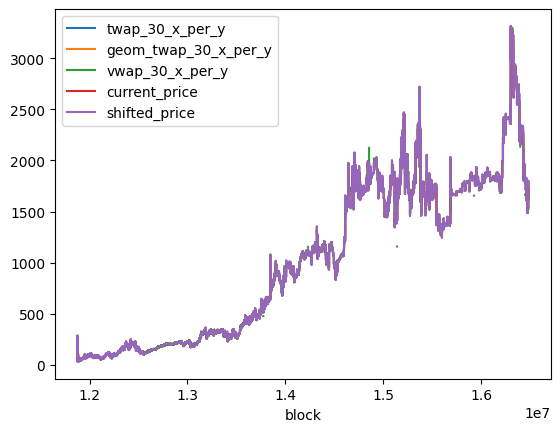

In [8]:
average_price_df.plot()

<AxesSubplot: xlabel='block'>

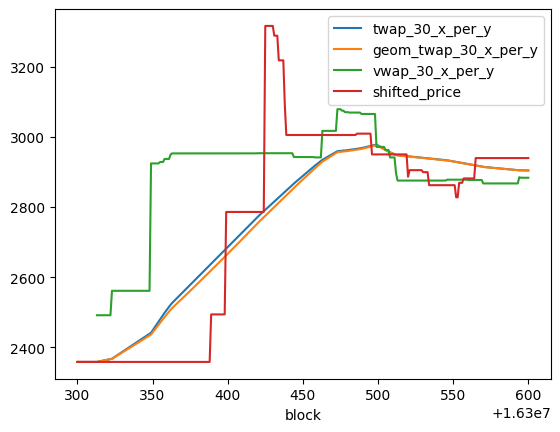

In [9]:
average_price_df.drop('current_price', axis=1)[(16300300 <= average_price_df.index) & (average_price_df.index <= 16300600)].plot()

# Reserve based price vs Volume weighted average price

Price is usually measured by the state of the reserves at the end of a block. Another way to meausre price is considering the rate each swap executes at. This can be chaotic with multiple swaps in either direction in a block, but we might group these rates within a block using a volume weighted average. Lets compare how these values would differ from a reserved based price

In [10]:
prices_df = DataFrame(block_df["block"])

# Add reserve based price
prices_df["reserve0/reserve1"] = block_df["reserve0"] / block_df["reserve1"]
prices_df["reserve1/reserve0"] = 1 / prices_df["reserve0/reserve1"]

# Add Volume based price, use last price if no volume exists
prices_df["volume0/volume1"] = (block_df["amount0In"] + block_df["amount0Out"]).divide(
    (block_df["amount1In"] + block_df["amount1Out"]).replace({ 0 : np.nan })).fillna(method='ffill')
prices_df["volume1/volume0"] = 1 / prices_df["volume0/volume1"]

# sperated volume values
prices_df["volume_sell_0_0per1"] = (block_df["amount0In"]).divide(
    (block_df["amount1Out"]).replace({ 0 : np.nan })).fillna(method='ffill')
prices_df["volume_sell_1_0per1"] = (block_df["amount0Out"]).divide(
    (block_df["amount1In"]).replace({ 0 : np.nan })).fillna(method='ffill')
prices_df["volume_sell_0_1per0"] = 1 / prices_df["volume_sell_0_0per1"]
prices_df["volume_sell_1_1per0"] = 1 / prices_df["volume_sell_1_0per1"]

prices_df = prices_df.set_index('block')

In [11]:
prices_df.head()

,reserve0/reserve1,reserve1/reserve0,volume0/volume1,volume1/volume0,volume_sell_0_0per1,volume_sell_1_0per1,volume_sell_0_1per0,volume_sell_1_1per0
block,,,,,,,,
11876000,51.70241,0.019341,16.895043,0.059189,5.888324,17.216868,0.169828,0.058083
11876001,5.98772,0.167008,16.895043,0.059189,5.888324,17.216868,0.169828,0.058083
11876002,5.98772,0.167008,16.895043,0.059189,5.888324,17.216868,0.169828,0.058083
11876003,5.98772,0.167008,16.895043,0.059189,5.888324,17.216868,0.169828,0.058083
11876004,5.98772,0.167008,16.895043,0.059189,5.888324,17.216868,0.169828,0.058083


<AxesSubplot: xlabel='block'>

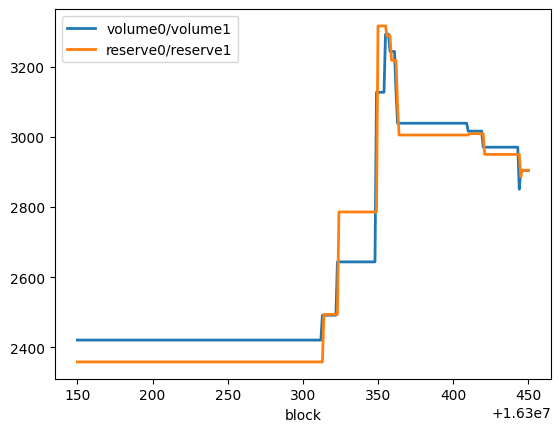

In [12]:
prices_df[["volume0/volume1", "reserve0/reserve1"]] \
    [(16300150 <= prices_df.index) & (prices_df.index <= 16300450)].plot(linewidth=2)

<AxesSubplot: xlabel='block'>

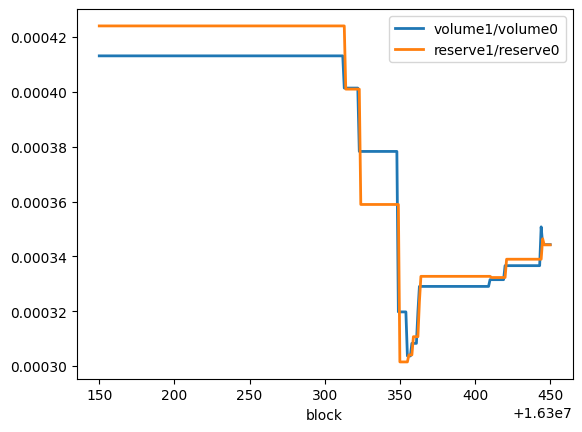

In [13]:
prices_df[["volume1/volume0", "reserve1/reserve0"]] \
    [(16300150 <= prices_df.index) & (prices_df.index <= 16300450)].plot(linewidth=2)

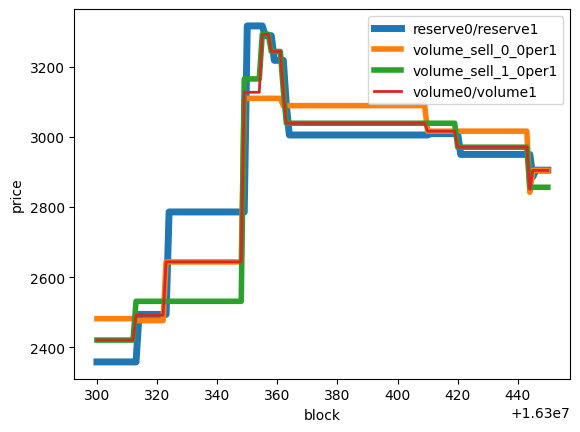

In [14]:

to_plot = prices_df[["reserve0/reserve1", "volume_sell_0_0per1", "volume_sell_1_0per1", "volume0/volume1"]] \
    [(16300300 <= prices_df.index) & (prices_df.index <= 16300450)]
plt.plot(to_plot[["reserve0/reserve1"]], label = "reserve0/reserve1", linewidth=5)
plt.plot(to_plot[["volume_sell_0_0per1", "volume_sell_1_0per1"]], label = ["volume_sell_0_0per1", "volume_sell_1_0per1"], linewidth=4)
plt.plot(to_plot[["volume0/volume1"]], label = "volume0/volume1", linewidth=2)
plt.xlabel("block")
plt.ylabel('price')
plt.legend()
plt.show()